In [ ]:
# Cell 1: Setup
"""
Notebook 6: LLM-Powered Medical Report Generation
Integration of CNN predictions with GPT-4 for automated reporting
"""

import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json

from src.models.custom_architectures import build_model
from src.explainability.gradcam import GradCAM, get_target_layer, analyze_gradcam_for_prompt
from src.llm.report_generator import MedicalReportGenerator
from src.data.dataset import get_transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set your OpenAI API key
os.environ['OPENAI_API_KEY'] =  # Replace with actual key

/home/usama/anaconda3/envs/analysis/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [11]:
# Cell 2: Load Model and Data
"""
Load trained model and sample images
"""

checkpoint = torch.load('../models/saved_models/efficientnet_b4_baseline.pth')
config = checkpoint['config']

model = build_model(config).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load test metadata
test_metadata = pd.read_csv('../data/processed/test_metadata.csv')

# Select diverse samples (one per grade + some challenging cases)
sample_indices = []
for grade in range(5):
    grade_samples = test_metadata[test_metadata['grade'] == grade]
    sample_indices.append(grade_samples.index[0])

print(f"Selected {len(sample_indices)} samples for report generation")


Selected 5 samples for report generation


In [13]:
# Cell 3: Generate Predictions with XAI
"""
Generate predictions with Grad-CAM explanations
"""

transform = get_transforms(224, augment=False)
target_layer = get_target_layer(model, config['model_name'])

predictions_data = []

for idx in sample_indices:
    row = test_metadata.iloc[idx]
    img_path = row['image_path']
    true_grade = row['grade']
    
    # Load image
    import cv2
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Preprocess
    augmented = transform(image=img_rgb)
    img_tensor = augmented['image'].unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, 1)[0]
        pred_class = output.argmax(1).item()
        confidence = probs[pred_class].item()
    
    # Generate Grad-CAM
    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate_cam(img_tensor, pred_class)
    gradcam.remove_hooks()
    
    # Analyze Grad-CAM
    gradcam_findings = analyze_gradcam_for_prompt(cam)
    
    # Collect probabilities
    top_k_probs = {i: probs[i].item() for i in range(5)}
    
    # Patient info (simulated)
    patient_info = {
        'id': f'P{idx:05d}',
        'age': np.random.randint(45, 80),
        'gender': np.random.choice(['Male', 'Female']),
        'bmi': np.random.uniform(22, 35),
        'knee_side': np.random.choice(['Left', 'Right'])
    }
    
    predictions_data.append({
        'image_path': img_path,
        'true_grade': true_grade,
        'prediction': pred_class,
        'confidence': confidence,
        'probabilities': top_k_probs,
        'gradcam_findings': gradcam_findings,
        'patient_info': patient_info,
        'cam_heatmap': cam
    })

print(f"Generated predictions and XAI for {len(predictions_data)} samples")


Generated predictions and XAI for 5 samples


In [15]:
# Cell 4: Initialize LLM Report Generator
"""
Initialize GPT-4 based report generator
"""

try:
    report_generator = MedicalReportGenerator(
        model='gpt-4',
        temperature=0.3
    )
    print("LLM Report Generator initialized")
except Exception as e:
    print(f"⚠️ Warning: Could not initialize LLM generator: {e}")
    print("Using fallback rule-based reporting")
    report_generator = None

LLM Report Generator initialized


In [17]:
# Cell 5: Generate Medical Reports
"""
Generate comprehensive medical reports using LLM
"""

reports = []

for idx, pred_data in enumerate(predictions_data):
    print(f"\nGenerating report {idx+1}/{len(predictions_data)}...")
    print(f"True Grade: {pred_data['true_grade']}, Predicted: {pred_data['prediction']}")
    
    if report_generator is not None:
        try:
            report = report_generator.generate_report(
                prediction=pred_data['prediction'],
                confidence=pred_data['confidence'],
                top_k_probs=pred_data['probabilities'],
                gradcam_findings=pred_data['gradcam_findings'],
                patient_info=pred_data['patient_info']
            )
            
            reports.append({
                'patient_id': pred_data['patient_info']['id'],
                'report': report,
                'prediction_data': pred_data
            })
            
            print("Report generated successfully")
            
        except Exception as e:
            print(f"❌ Error: {e}")
            # Use fallback
            report = report_generator._generate_fallback_report(
                pred_data['prediction'],
                pred_data['confidence'],
                pred_data['probabilities'],
                pred_data['gradcam_findings'],
                pred_data['patient_info']
            )
            reports.append({
                'patient_id': pred_data['patient_info']['id'],
                'report': report,
                'prediction_data': pred_data
            })
    else:
        # Fallback report
        report = f"""
KNEE OSTEOARTHRITIS ASSESSMENT REPORT
Patient ID: {pred_data['patient_info']['id']}

CLASSIFICATION: Grade {pred_data['prediction']} ({pred_data['confidence']:.1%} confidence)

FINDINGS:
{pred_data['gradcam_findings']}

This is an automated preliminary assessment requiring radiologist review.
"""
        reports.append({
            'patient_id': pred_data['patient_info']['id'],
            'report': report,
            'prediction_data': pred_data
        })

print(f"\nGenerated {len(reports)} medical reports")


Generating report 1/5...
True Grade: 0, Predicted: 0
Error generating report: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

Report generated successfully

Generating report 2/5...
True Grade: 1, Predicted: 2
Error generating report: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip inst

In [6]:
# Cell 6: Display Sample Reports
"""
Display generated reports
"""

for idx, report_data in enumerate(reports[:3]):  # Show first 3
    print("\n" + "="*80)
    print(f"REPORT {idx+1}")
    print("="*80)
    print(report_data['report'])
    print("="*80)



REPORT 1

KNEE OSTEOARTHRITIS ASSESSMENT REPORT
Generated: 2025-11-12 17:10:40
Report Type: AI-Assisted Preliminary Analysis


CLINICAL IMPRESSION:
The AI model has classified this knee X-ray as Kellgren-Lawrence Grade 0 
with 44.5% confidence. No radiographic features of osteoarthritis

PROBABILITY DISTRIBUTION:
  Grade 0: 44.5%
  Grade 1: 42.8%
  Grade 2: 12.6%
  Grade 3: 0.1%
  Grade 4: 0.0%

EXPLAINABLE AI FINDINGS:
The model's attention (Grad-CAM) highlights the following regions:
  - Peak attention at coordinates (4, 1) with intensity 1.00
  - 6.1% of the image shows high model attention (>0.7)
  - Relatively balanced medial and lateral compartment attention


RECOMMENDATIONS:
  • No immediate treatment required
  • Encourage regular physical activity and weight management
  • Routine follow-up in 2-3 years or if symptoms develop

LIMITATIONS:
This is an AI-assisted preliminary assessment. Final diagnosis must be confirmed 
by a qualified radiologist with clinical correlation. T

In [18]:
# Cell 7: Save Reports
"""
Save all reports to files
"""

reports_dir = Path('../reports/generated_reports')
reports_dir.mkdir(parents=True, exist_ok=True)

for report_data in reports:
    patient_id = report_data['patient_id']
    report = report_data['report']
    
    # Save text report
    report_path = reports_dir / f'{patient_id}_report.txt'
    with open(report_path, 'w') as f:
        f.write(report)
    
    # Save metadata
    metadata = {
        'patient_id': patient_id,
        'true_grade': int(report_data['prediction_data']['true_grade']),
        'predicted_grade': int(report_data['prediction_data']['prediction']),
        'confidence': float(report_data['prediction_data']['confidence']),
        'patient_info': report_data['prediction_data']['patient_info']
    }
    
    metadata_path = reports_dir / f'{patient_id}_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

print(f"\nSaved {len(reports)} reports to {reports_dir}")


Saved 5 reports to ../reports/generated_reports


In [19]:
# Cell 8: Report Quality Analysis
"""
Analyze report generation statistics
"""

# Calculate statistics
correct_predictions = sum(1 for r in reports 
                         if r['prediction_data']['prediction'] == r['prediction_data']['true_grade'])

accuracy = correct_predictions / len(reports)
avg_confidence = np.mean([r['prediction_data']['confidence'] for r in reports])

# Per-grade analysis
grade_stats = {grade: {'count': 0, 'correct': 0} for grade in range(5)}

for r in reports:
    true_grade = r['prediction_data']['true_grade']
    pred_grade = r['prediction_data']['prediction']
    
    grade_stats[true_grade]['count'] += 1
    if true_grade == pred_grade:
        grade_stats[true_grade]['correct'] += 1

print("\n📊 REPORT GENERATION STATISTICS")
print("="*60)
print(f"Total Reports Generated: {len(reports)}")
print(f"Overall Accuracy: {accuracy:.1%}")
print(f"Average Confidence: {avg_confidence:.1%}")
print("\nPer-Grade Performance:")
print("-"*60)

for grade, stats in grade_stats.items():
    if stats['count'] > 0:
        grade_acc = stats['correct'] / stats['count']
        print(f"Grade {grade}: {stats['correct']}/{stats['count']} correct ({grade_acc:.1%})")

print("="*60)



📊 REPORT GENERATION STATISTICS
Total Reports Generated: 5
Overall Accuracy: 80.0%
Average Confidence: 80.1%

Per-Grade Performance:
------------------------------------------------------------
Grade 0: 1/1 correct (100.0%)
Grade 1: 0/1 correct (0.0%)
Grade 2: 1/1 correct (100.0%)
Grade 3: 1/1 correct (100.0%)
Grade 4: 1/1 correct (100.0%)


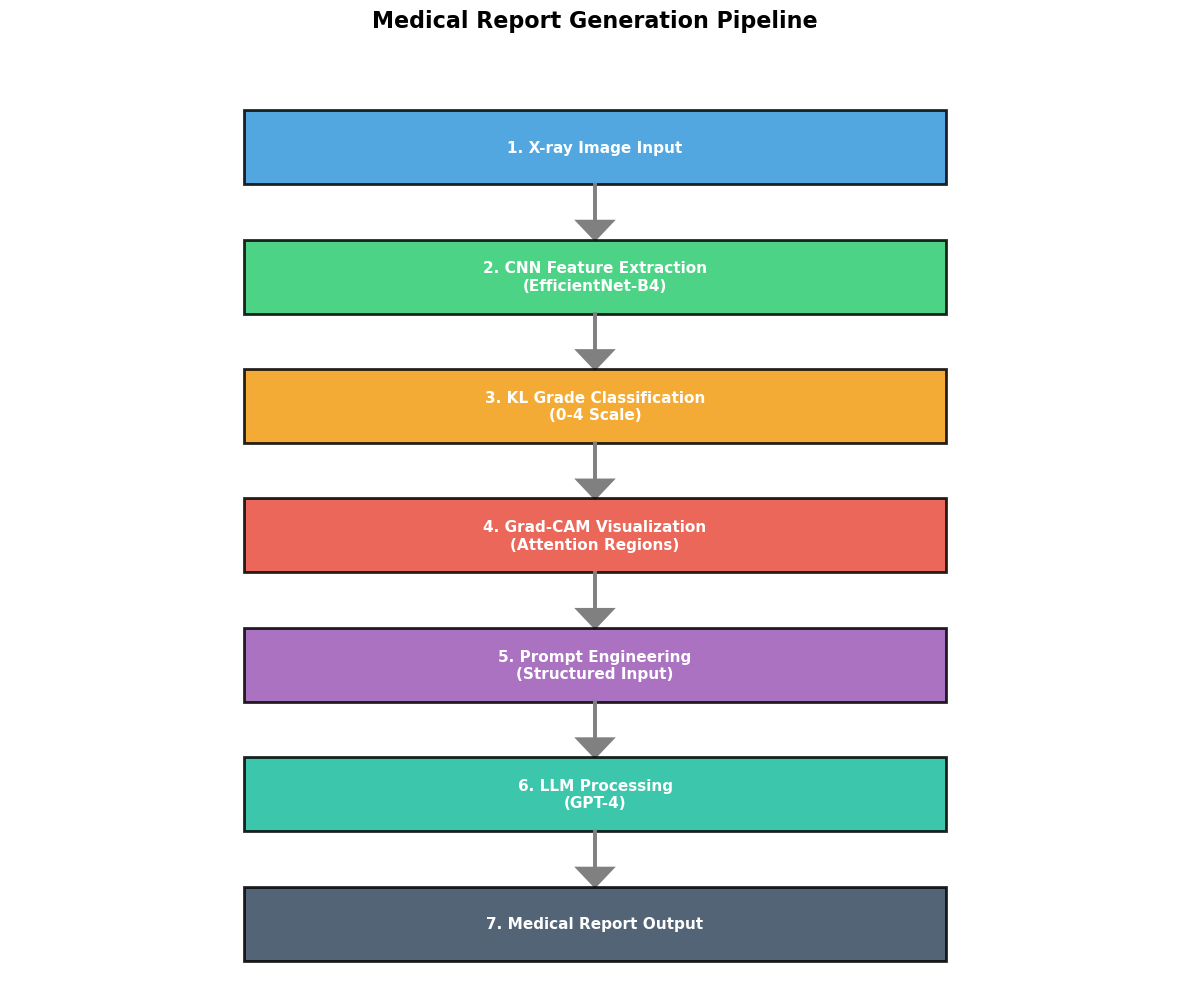

In [36]:
# Cell 9: Visualize Report Generation Pipeline
"""
Create flowchart visualization of the pipeline
"""

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('off')

# Pipeline steps
steps = [
    "1. X-ray Image Input",
    "2. CNN Feature Extraction\n(EfficientNet-B4)",
    "3. KL Grade Classification\n(0-4 Scale)",
    "4. Grad-CAM Visualization\n(Attention Regions)",
    "5. Prompt Engineering\n(Structured Input)",
    "6. LLM Processing\n(GPT-4)",
    "7. Medical Report Output"
]

colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#1abc9c', '#34495e']

# Positions and layout parameters
box_height = 0.08
vertical_gap = 0.06
top_y = 0.9
y_positions = [top_y - i * (box_height + vertical_gap) for i in range(len(steps))]

for i, (step, color, y) in enumerate(zip(steps, colors, y_positions)):
    # Draw box
    rect = plt.Rectangle(
        (0.2, y - box_height / 2), 0.6, box_height,
        facecolor=color, edgecolor='black',
        linewidth=2, alpha=0.85
    )
    ax.add_patch(rect)
    
    # Add text
    ax.text(0.5, y, step, ha='center', va='center',
            fontsize=11, fontweight='bold', color='white')
    
    # Add arrow between boxes
    if i < len(steps) - 1:
        y_next = y_positions[i + 1]
        ax.arrow(
            0.5, y - box_height / 2, 0, 
            (y_next + box_height / 2) - (y - box_height / 2),
            head_width=0.03, head_length=0.02,
            fc='gray', ec='gray', linewidth=2,
            length_includes_head=True
        )

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title(
    'Medical Report Generation Pipeline',
    fontsize=16, fontweight='bold', pad=20
)

plt.tight_layout()
plt.savefig('../reports/figures/report_generation_pipeline.png', dpi=300, bbox_inches='tight')
plt.show()


In [37]:
# Cell 10: Summary and Export
"""
Create comprehensive summary
"""

summary = {
    'total_reports': len(reports),
    'accuracy': float(accuracy),
    'avg_confidence': float(avg_confidence),
    'model_used': config['model_name'],
    'llm_model': 'gpt-4' if report_generator else 'rule-based',
    'per_grade_stats': {
        f'grade_{k}': {
            'count': v['count'],
            'correct': v['correct'],
            'accuracy': v['correct']/v['count'] if v['count'] > 0 else 0
        }
        for k, v in grade_stats.items()
    }
}

# Save summary
summary_path = reports_dir / 'generation_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print("\nLLM Report Generation Complete!")
print("="*60)
print(f"Reports saved to: {reports_dir}")
print(f"Summary saved to: {summary_path}")
print("="*60)


LLM Report Generation Complete!
Reports saved to: ../reports/generated_reports
Summary saved to: ../reports/generated_reports/generation_summary.json
